In [1]:
import imp
import sys
sys.path.insert(0,"/home/ljw/Dropbox/dev/libpysal3")
import libpysal as lp
import geopandas as gpd
import numpy as np
from bounder import region
from bounder.region.abstracts import Constraint
from bounder.region.methods import AZP
from bounder.region import utils as rut
imp.reload(region)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
south = gpd.read_file('/home/ljw/Dropbox/dev/pysal/pysal/examples/south/south.shp').query('STATE_NAME == "Texas"')
south.index = np.arange(len(south))
W_start = lp.weights.Contiguity.Rook.from_dataframe(south)
south.crs = {'init':'epsg:4269'}
south = south.to_crs(epsg=5070)
W_fin = lp.weights.Contiguity.Rook.from_dataframe(south)
np.testing.assert_allclose(W_start.sparse.toarray(), W_fin.sparse.toarray())

In [3]:
from bounder.region.abstracts import Constraint

In [37]:
AZP_ = region.methods.AZP(objective=dict(GI89 = lambda x: x.var()), 
                          constraints=Constraint(FH90 = lambda x: x.count()).above(30),
                          remember=True)
AZP_.add_data(south)

In [38]:
AZP_._log = lambda x: x

In [39]:
pts = pd.DataFrame(lp.weights.util.get_points_array(south.geometry))
pts.index = south.index
AZP_.initialize(5, data=pts, w=W_fin)

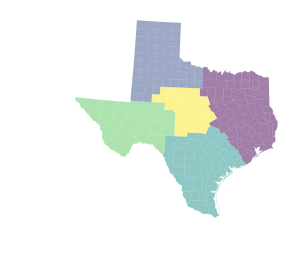

In [40]:
AZP_.plot()
plt.show()

(<matplotlib.figure.Figure at 0x7feee3d61710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feee3d67080>)

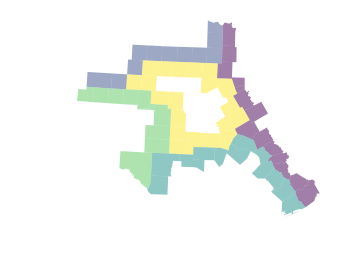

In [41]:
AZP_.plot_boundary()

In [42]:
AZP_._data.groupby('current_labels').count()

,BLK60,BLK70,BLK80,BLK90,CNTY_FIPS,COFIPS,DNL60,DNL70,DNL80,DNL90,...,STATE_FIPS,STATE_NAME,STFIPS,UE60,UE70,UE80,UE90,geometry,0,1
current_labels,,,,,,,,,,,,,,,,,,,,,
0,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
1,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
2,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
3,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
4,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29


In [43]:
AZP_.refine(rounds=10, progressbar = True)

100%|██████████| 50/50 [00:30<00:00,  1.30it/s]


In [44]:
AZP_.refine(passes=10, target_label=3, progressbar=True)

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


In [45]:
AZP_.slack()

[array([-62, -31, -21,  16,  -6])]

In [46]:
AZP_.tabu_list

[(119, 105),
 (107, 112),
 (87, 81),
 (105, 121),
 (229, 224),
 (122, 119),
 (87, 102),
 (102, 81),
 (88, 105),
 (228, 229),
 (88, 68),
 (102, 107),
 (102, 114),
 (122, 121),
 (217, 228),
 (179, 166),
 (179, 180),
 (179, 167),
 (117, 100),
 (180, 179),
 (140, 117),
 (150, 140),
 (105, 88),
 (122, 105),
 (141, 122),
 (157, 141),
 (195, 180)]

In [47]:
subset = AZP_.alist[AZP_.alist.focal.isin(AZP_._data.query('current_labels == 3').index)]

In [48]:
AZP_._data[AZP_._data.index.isin(subset.neighbor)].current_labels.unique()

array([1, 4, 3])

In [49]:
not_in_tabulist = [val not in AZP_.tabu_list for val in list(map(tuple, subset[['focal', 'neighbor']].values))]

In [50]:
AZP_._data[AZP_._data.index.isin(subset[not_in_tabulist].neighbor)].current_labels.unique()

array([1, 4, 3])

(<matplotlib.figure.Figure at 0x7feee3e76518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feee3e712e8>)

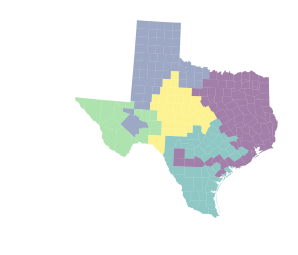

In [51]:
AZP_.plot()

In [52]:
AZP_.constraints[0].satisfied(AZP_._data.groupby('current_labels'))

True

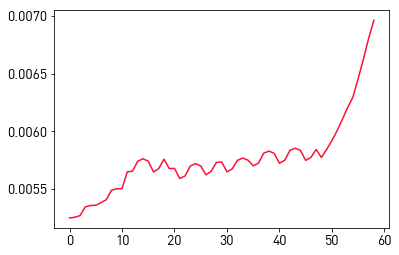

In [53]:
plt.plot([move.new_objective for move in AZP_._swaps])